#IMPORTING LIBRARIES AND DOWNLOADING DATASET

In [ ]:
# if DOWNLOAD_DATASET = True: if is the first time you run the code--> the dataset has to be downloaded and saved in a Google Drive folder
# if DOWNLOAD_DATASET = False: if the dataset is already present in the google drive folder 'DL_project/dataset/train', 'DL_project/dataset/val' and 'DL_project/dataset/test' and
# therefore you don't need to download it again
DOWNLOAD_DATASET = True

In [ ]:
! pip install pytorch-lightning
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 43.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 11.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import json
import torch
import torchmetrics
import numpy as np
import math
import os
from torchmetrics import Accuracy
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.nn import Module, LSTM, Conv2d, Linear, Flatten, MaxPool2d, BCEWithLogitsLoss, CrossEntropyLoss, Dropout, Tanh, ReLU, Sequential, Softmax, GRU, RNN, Embedding
from torch.optim import Adam, SGD
import torch.nn.functional as F
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from datasets import list_datasets, load_dataset
from pprint import pprint

In [ ]:
# variables:
# Math Dataset constants (from paper)
# input chars are selected from basic ASCII chars
VOCAB_SIZE = 95
MAX_QUESTION_SIZE = 162
MAX_ANSWER_SIZE = 32

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**The mathematics dataset:**

The dataset I use for this task is the mathematics dataset which is a set of math problems involving question and answers in a free-form textual input/output format. The domains of the math problems are various: arithmetic, algebra, probability and calculus and there exists multiple subset of problem which cover a specific type of questions. Example of subset problems are:
- algebra__linear_1d, algebra__linear_2d, algebra__polynomial_roots, arithmetic__add_or_sub, arithmetic__div, arithmetic__mul, calculus__differentiate

In [ ]:
# subset_list = ['algebra__linear_1d', 'algebra__linear_2d', 'algebra__polynomial_roots', 'algebra__sequence_next_term', 'arithmetic__add_or_sub', 'arithmetic__div', 'arithmetic__mixed', 'arithmetic__mul', 'calculus__differentiate']
subset_list = ['algebra__linear_1d', 'arithmetic__add_or_sub', 'numbers__place_value', 'numbers__round_number', 'calculus__differentiate']

if DOWNLOAD_DATASET:
  dataset = []
  for sub in subset_list:
    sub_dataset = load_dataset('math_dataset', sub)

    dataset.append(sub_dataset)

Ogni subset è una classe *datasets.dataset_dict.DatasetDict* che contiene 2 tuple (.items()) e oogni tupla ha 2 elementi:
* ('train', Dataset({
    features: ['question', 'answer'],
    num_rows: 1999998
}))
* ('test', Dataset({
    features: ['question', 'answer'],
    num_rows: 10000
}))

I due elementi sono il primo è 'train' o 'test' e il secondo elemento è un Dataset (classe 'datasets.arrow_dataset.Dataset'). Da questa struttura Dataset è possibile prendere l'insieme di tutti i samples che ci servono.
Ogni sample è di questo tipo:
- {'question': "b'Solve 236*n - 244*n = -32 for n.\\n'", 'answer': "b'4\\n'"}

e quindi contiene il campo 'question' e il campo 'answer' tipo dizionario.

Saving dataset's samples on my google drive so that I don't have to download it again every time I restart the runtime.


In [ ]:
if DOWNLOAD_DATASET:

  for subset, subset_name in zip(dataset, subset_list):
    train_i=0
    train_data = []
    for i in subset['train']:
      if train_i < 10000: #1999998:
        # clean questions
        qs = i['question']
        clean_qs = qs[2:][:-3]
        i['question'] = clean_qs
        # clean answers
        ans = i['answer']
        clean_ans = ans[2:][:-3]
        i['answer'] = clean_ans
        train_data.append(i)

        train_i += 1

    if os.path.isdir('/content/drive/MyDrive/DL_project/dataset/train') is False:
      os.makedirs('/content/drive/MyDrive/DL_project/dataset/train')
    json.dump(train_data, open(f'/content/drive/MyDrive/DL_project/dataset/train/{subset_name}.json', 'a'))

    val_data = []
    test_data = []
    tot = 10000 #len(subset['test'])
    for count, i in enumerate(subset['test']):
      # clean questions and answers
      qs = i['question']
      clean_qs = qs[2:][:-3]
      i['question'] = clean_qs
      ans = i['answer']
      clean_ans = ans[2:][:-3]
      i['answer'] = clean_ans

      if count < (int(2/3*tot)):
        val_data.append(i)
      elif count >= (int(2/3*tot)) and count <= tot:
        test_data.append(i)
      else:
        break

    if os.path.isdir('/content/drive/MyDrive/DL_project/dataset/val') is False:
      os.makedirs('/content/drive/MyDrive/DL_project/dataset/val')
    if os.path.isdir('/content/drive/MyDrive/DL_project/dataset/test') is False:
      os.makedirs('/content/drive/MyDrive/DL_project/dataset/test')
    json.dump(val_data, open(f'/content/drive/MyDrive/DL_project/dataset/val/{subset_name}.json', 'a'))
    json.dump(test_data, open(f'/content/drive/MyDrive/DL_project/dataset/test/{subset_name}.json', 'a'))

# CREATING THE DATASET...

Since the fact that in the dataset the questions and the answers use a common alphabet of size 95 (upper and lower case characters, digits, and punctuation characters), I encoded each character of questions and answers following the  ASCII standard character encoding. ASCII has just 128 code points, of which only 95 are printable characters (from 32 to 126) so I will use the 95 code points related to the 95 printable characters shifted by 32 position to have the code points range going from 1 to 95 plus the zero (0) that is used for PAD; thus in total my vocabulary size will be 95 + 1 (PAD=0).

ASCII TABLE:

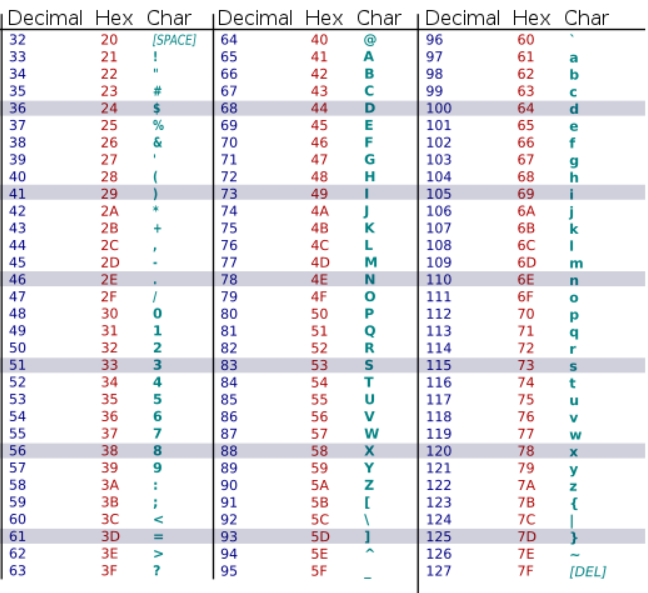

In [ ]:
def encode_string(s):
  pad_encoded = ord(" ") # pad = " " which encoded is 32
  list_encoded = []
  for char in list(s):
    list_encoded.append(ord(char))
  string_encoded = np.array(list_encoded)

  string_encoded = string_encoded - pad_encoded + 1

  return string_encoded

def decode_string(string_encoded):
  # input string_encoded is a tensor
  pad_encoded = ord(" ")
  string_encoded = string_encoded.tolist()
  s = ""
  for i, encoding in enumerate(string_encoded):
    if i==0:
      s = chr(int(encoding + pad_encoded - 1))
    else:
      s += chr(int(encoding + pad_encoded - 1))
  return s

Example of the *decode_string* function:

In [ ]:
s = torch.Tensor([52, 80, 77, 87, 70,  1, 14, 19, 25, 19, 11, 69,  1, 12,  1, 26, 19, 26, 1, 14,  1, 18, 24, 25,  1, 30,  1, 14, 18, 19, 19, 20,  1, 71, 80, 83, 1, 69, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
dec_s = decode_string(s)
print(dec_s)
#  Solve -282*d + 929 - 178 = -1223 for d.

Solve -282*d + 929 - 178 = -1223 for d.


In [ ]:
class SubDataset(Dataset):
  # dataset_path could be -train, val or test-
  def __init__(self, subset_path, encode_string):
    self.sample_elements = []
    self.subset_path = subset_path
    self.encode_string = encode_string

    self.extract_data()

  def extract_data(self):
    with open(self.subset_path, 'r') as fp:
      data = json.load(fp)
    for item in data:
      question = item['question']
      q_enc = self.encode_string(question)
      answer = item['answer']
      a_enc = self.encode_string(answer)
      self.sample_elements.append((q_enc, question, a_enc, answer))

  def __len__(self):  # returns the number of samples in our dataset
    return len(self.sample_elements)

  def __getitem__(self, i):
    return self.sample_elements[i]

In [ ]:
def collate_function(dataset):
  # quest_list/ans_list are lists of encoded questions and encoded answers
  question_list = []
  answer_list = []

  for sample in dataset:

    q_enc = torch.tensor(sample[0])
    question_list.append(q_enc)

    a_enc = torch.tensor(sample[2])
    answer_list.append(a_enc)

  # apply the function pad_sequence
  quest_list = pad_sequence(question_list, batch_first=True, padding_value=0)
  ans_list = pad_sequence(answer_list, batch_first=True, padding_value=0)
  return quest_list, ans_list

In [ ]:
class DataModule(pl.LightningDataModule):
  def __init__(self, subset_list, encode_string):
    super().__init__()
    self.subset_list = subset_list
    self.encode_string = encode_string

  def setup(self, stage: str):
    # Assign train/val datasets for use in dataloaders
    if stage == "train":
      all_train_datasets = []
      for subset_name in self.subset_list:
        TRAIN_PATH = f'/content/drive/MyDrive/DL_project/dataset/train/{subset_name}.json'
        single_module_train_ds = SubDataset(TRAIN_PATH, self.encode_string)
        print("Number of TRAIN samples of module ", subset_name, ": ", len(single_module_train_ds))
        all_train_datasets.append(single_module_train_ds)
      self.train_dataset = ConcatDataset(all_train_datasets)
      print("Number of samples of the whole TRAINING SET: ", len(self.train_dataset))

    if stage == "val":
      all_val_datasets = []
      for subset_name in self.subset_list:
        VAL_PATH = f'/content/drive/MyDrive/DL_project/dataset/val/{subset_name}.json'
        single_module_val_ds = SubDataset(VAL_PATH, self.encode_string)
        print("Number of VAL samples of module ", subset_name, ": ", len(single_module_val_ds))
        all_val_datasets.append(single_module_val_ds)
      self.val_dataset = ConcatDataset(all_val_datasets)
      print("Number of samples of the whole VALIDATION SET: ", len(self.val_dataset))

    if stage == "test":
      all_test_datasets = []
      for subset_name in self.subset_list:
        TEST_PATH = f'/content/drive/MyDrive/DL_project/dataset/test/{subset_name}.json'
        single_module_test_ds = SubDataset(TEST_PATH, self.encode_string)
        print("Number of TEST samples of module ", subset_name, ": ", len(single_module_test_ds))
        all_test_datasets.append(single_module_test_ds)
      self.test_dataset = ConcatDataset(all_test_datasets)
      print("Number of samples of the whole TEST SET: ", len(self.test_dataset))

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=128, collate_fn = collate_function)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=128, collate_fn = collate_function)

  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=128, collate_fn = collate_function)


In [ ]:
data_mod = DataModule(subset_list, encode_string)

In [ ]:
data_mod.setup('train')
train_loader = data_mod.train_dataloader()

Number of TRAIN samples of module  algebra__linear_1d :  10000
Number of TRAIN samples of module  arithmetic__add_or_sub :  10000
Number of TRAIN samples of module  numbers__place_value :  10000
Number of TRAIN samples of module  numbers__round_number :  10000
Number of TRAIN samples of module  calculus__differentiate :  10000
Number of samples of the whole TRAINING SET:  50000


In [ ]:
data_mod.setup('val')
val_loader = data_mod.val_dataloader()

Number of VAL samples of module  algebra__linear_1d :  6666
Number of VAL samples of module  arithmetic__add_or_sub :  6666
Number of VAL samples of module  numbers__place_value :  6666
Number of VAL samples of module  numbers__round_number :  6666
Number of VAL samples of module  calculus__differentiate :  6666
Number of samples of the whole VALIDATION SET:  33330


In [ ]:
data_mod.setup('test')
test_loader = data_mod.test_dataloader()

Number of TEST samples of module  algebra__linear_1d :  3334
Number of TEST samples of module  arithmetic__add_or_sub :  3334
Number of TEST samples of module  numbers__place_value :  3334
Number of TEST samples of module  numbers__round_number :  3334
Number of TEST samples of module  calculus__differentiate :  3334
Number of samples of the whole TEST SET:  16670


Some examples of the dataset:

In [ ]:
j=0; x=0
for i in val_loader:
  if j < 1:
    print("Some dataset samples: \n")
    for (q_enc, a_enc) in zip(i[0], i[1]):
      if x < 3:
        print("SAMPLE N°", x)
        print("Question encoded: ", "\n", q_enc, "\n")
        print("Question: ", "\n", decode_string(q_enc), "\n")
        print("Answer encoded: ", "\n", a_enc, "\n")
        print("Answer: ", "\n", decode_string(a_enc), "\n")
        x+=1

    j+=1

Some dataset samples: 

SAMPLE N° 0
Question encoded:  
 tensor([52, 80, 77, 87, 70,  1, 14, 19, 25, 19, 11, 69,  1, 12,  1, 26, 19, 26,
         1, 14,  1, 18, 24, 25,  1, 30,  1, 14, 18, 19, 19, 20,  1, 71, 80, 83,
         1, 69, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]) 

Question:  
 Solve -282*d + 929 - 178 = -1223 for d. 

Answer encoded:  
 tensor([24,  0,  0]) 

Answer:  
 7 

SAMPLE N° 1
Question encoded:  
 tensor([52, 80, 77, 87, 70,  1, 21, 26, 11, 77,  1, 12,  1, 21, 22, 11, 77,  1,
        14,  1, 18, 19, 22,  1, 14,  1, 23, 20,  1, 30,  1, 17,  1, 71, 80, 83,
         1, 77, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]) 

Question:  
 Solve 49*l + 45*l - 125 - 63 = 0 for l. 

Answer encoded:  
 tensor([19,  0,  0]) 

Answer:  
 2 

SAMPLE N° 2
Question encoded:  
 tensor([52, 80, 77, 87, 70,  1, 14, 23, 21, 11, 85,  1, 12,  1, 18, 20, 25, 24,
         1, 14,  1, 25, 21, 25,  1, 12,  1, 26, 20, 2

# 1° APPROACH: baseline SIMPLE LSTM

I called the first approach, valid for the first baseline method, **Simple LSTM**.  I take the general idea of the "Simple LSTM" method described by the original paper of the mathematics-dataset (https://arxiv.org/pdf/1904.01557v1.pdf).

A peculiarity of Simple LSTM is that, during training, the network receives in input not only the input encoded question but also the target answer, thus it's like the network has a "teacher" that during training helps it to learn faster. Instead during the validation and test steps the network makes uses only of the input question in order to predict the answer.

The network works like this: it takes in input the input question and the target answer and transforms them in one-hot encoding inputs. After that, the input question is feeded into the LSTM (with hidden_size = 2048) one character at a time and then, always one character at a time, the same LSTM net outputs the answer using as first input the last output of the initial lstm and then for the subsequent time steps the target answers (if we are in the training loop) or the input question (if we are in the validation or test loop) until the predicted answer is generated.

In [ ]:
class SimpleLSTM(Module):
  def __init__(self, vocab_size, max_target_size):
    super().__init__()
    self.vocab_size = vocab_size
    self.max_target_size = max_target_size
    self.hidden_size = 2048

    self.lstm = LSTM(self.vocab_size, self.hidden_size)
    self.from_lstm_to_ans = Linear(self.hidden_size, self.vocab_size)
    self.softmax = Softmax(dim=2)

  def forward(self, input_quest, target_ans = None):
    '''
      size of input_quest = (batch, seq_length_q)
      size of target_ans  = (batch, seq_length_a)
    '''
    batch_size = input_quest.size(dim=0)
    max_quest_size = input_quest.size(dim=1)
    # transform the input question in a one-hot tensor (char in vocab 95)
    input_quest = F.one_hot(input_quest, self.vocab_size) # (batch, seq_len_q, vocab_size=95)
    if target_ans is not None:
      max_ans_size = target_ans.size(dim=1)
      target_ans = F.one_hot(target_ans, self.vocab_size) # (batch, seq_len_a, vocab_size=95)

    # initializing the hidden state and cell state
    hidden_s = torch.zeros(1, batch_size, self.hidden_size, requires_grad=True).to(device)
    cell_s = torch.zeros(1, batch_size, self.hidden_size, requires_grad=True).to(device)

    # creating memory for the output sequence
    if target_ans is not None:
      output = torch.empty(max_ans_size, batch_size, self.vocab_size).to(device)
      output_one_hot = torch.empty(max_ans_size, batch_size, self.vocab_size).to(device)
      target_ans = target_ans.transpose(0,1) # (seq_len_a, batch, vocab_size)
    else:
      output = torch.empty(self.max_target_size, batch_size, self.vocab_size).to(device)
      output_one_hot = torch.empty(self.max_target_size, batch_size, self.vocab_size).to(device)
    input_quest = input_quest.transpose(0,1)

    # Now I give the input question in input to the lstm, one character at time
    for c in range(max_quest_size):
      '''
        size of hidden_s and cell_s:         (1, batch, 2048]
        size of input_quest:                 (seq_len_q, batch, vocab_size)
        size of input_quest[c]:              (batch, vocab_size)
        size of input_quest[c].unsqueeze(0): (1, batch, vocab_size)
      '''
      out_lstm, (hidden_s, cell_s) = self.lstm(input_quest[c].unsqueeze(0).float(), (hidden_s, cell_s))
      '''
        size of out_lstm: (1, batch, 2048)  hidden_size = 2048
        size of hidden_s: (1, batch, 2048)  hidden_size = 2048
      '''

    # Now finally we generate the output, always one character at time
    if target_ans is not None:
      max_out_size = max_ans_size
    else:
      max_out_size = self.max_target_size
    for c in range(max_out_size):
      if c == 0:
        first_out = self.from_lstm_to_ans(out_lstm) # linear layer, size of first_out: (1, batch, vocab_size) 1 char x ogni sample in the batch
        first_out_softmax = self.softmax(first_out) # (1, batch, vocab_size)
        first_out_max = torch.max(first_out_softmax, dim=2)
        out = F.one_hot(first_out_max[1], self.vocab_size)
        output[c] = first_out_softmax
        output_one_hot[c] = out
        first_out_to_input = first_out.clone()
        out_lstm, (hidden_s, cell_s) = self.lstm(first_out_to_input, (hidden_s, cell_s))
      else:
        next_output = self.from_lstm_to_ans(out_lstm) # next_output: (1, batch, vocab_size); next_output_softmax = (1, batch, vocab_size)
        # the output is a probability distribution: each element is non-negative and the sum over all components is 1, the most probable character at time step c in chosen
        next_output_softmax = self.softmax(next_output)
        next_output_max = torch.max(next_output_softmax, dim=2) # torch.return_types.max(values=tensor([..]), indices=tensor([..])
        out = F.one_hot(next_output_max[1], self.vocab_size) # (1, batch, vocab_size)
        output[c] = next_output_softmax
        output_one_hot[c] = out
        if target_ans is not None: # training (we have the target answer)
          '''
            size of target_ans:                  (seq_len_a, batch, vocab_size)
            size of target_ans[c]:               (batch, vocab_size)
            size of target_ans[c].unsqueeze(0):  (1, batch, vocab_size)
          '''
          out_lstm, (hidden_s, cell_s) = self.lstm(target_ans[c].unsqueeze(0).float(), (hidden_s, cell_s))
        else: # validation and test (we do not have the target answer, we have just the input)
          next_output_to_input = next_output.clone()
          out_lstm, (hidden_s, cell_s) = self.lstm(next_output_to_input, (hidden_s, cell_s))
    '''
      size of output (before transpose):  (seq_len, batch, vocab_size)
      size of output (after transpose):   (batch, seq_len, vocab_size)
    '''
    output=output.transpose(0,1)
    output_one_hot=output_one_hot.transpose(0,1)
    return output_one_hot, output

**About the training:**

As loss function I used the binary cross entropy loss (*BCEWithLogitsLoss*), as optimizer the Adam optimizer with learning rate lr = 0.0001 (slightly different from the paper), beta1 = 0.9, beta2 = 0.995, epsilon = 1e-09.

In this approach, as for all the others, the batch size is equal to 64, because after multiple attempts it seems to give the better results.  

The model predicts the characters of the answer in a greedy-way, it means that the most probable character is chosen among all the other characters (using softmax function) for the output sequence.

To define and to train the model I used pytorch lightning in order to make the training, validation and test steps more easier to write and read.

The accuracy is computed by picking each predicted answer and comparing it with the target answer with equality measure. The final accuracy is: num_correct_answers/num_tot_answers*100(%).

In [ ]:
class LightningModule(pl.LightningModule):
  def __init__(self, simpleLSTM):
    super().__init__()
    self.simpleLSTM = simpleLSTM.to(device)
    self.loss = BCEWithLogitsLoss()
    self.n_tot = 0
    self.n_correct = 0

  def forward(self, input_q, target_a, teacher):
    if teacher: # train
      predicted_a_one_hot, predicted_a = self.simpleLSTM(input_q.to(device), target_a.to(device))
    else: # val and test
      predicted_a_one_hot, predicted_a = self.simpleLSTM(input_q.to(device))
    '''
      size of predicted_a (train):      (batch, target_a.size(), vocab_size)
      size of predicted_a (val, test):  (batch, MAX_ANSWER_SIZE, vocab_size)
    '''
    target_a = F.one_hot(target_a, 95)
    # for train: target_a and predicted_a should have the same size
    # for val and test: target_a and predicted_a are of different size because the sequence of target_a is taken from pad_esequence in collate_fn (variable but < max_ans_size=35)
    if target_a.size() != predicted_a.size():
      diff_dim = int(predicted_a.size(dim=1)) - int(target_a.size(dim=1))
      target_a = F.pad(target_a, pad=(0, 0, 0, diff_dim), mode="constant", value=0)

    res = {'predicted_answer': predicted_a}
    res['target_answer'] = target_a
    acc = self.compute_accuracy(predicted_a_one_hot, target_a)
    res['tot'] = self.n_tot
    res['n_correct'] = self.n_correct
    res['accuracy'] = acc
    loss = self.compute_loss(predicted_a, target_a)
    res['loss'] = loss
    return res

  def training_step(self, batch, batch_idx):
    teacher = True
    input_quest, target_ans = batch
    res = self.forward(input_quest, target_ans, teacher)
    train_loss = res['loss']
    train_acc = res['accuracy']
    num_tot_answers = res['tot']
    num_correct_answers = res['n_correct']
    self.log('train_loss', train_loss, on_epoch=True, prog_bar=True, logger=True)
    self.log('train_accuracy', train_acc, on_epoch=True, prog_bar=True, logger=True)
    self.log('total number of answers predicted', int(num_tot_answers), on_epoch=True, prog_bar=True, logger=True)
    self.log('number of correct answers', int(num_correct_answers), on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    teacher = False
    input_quest, target_ans = batch
    res = self.forward(input_quest, target_ans, teacher)
    ans_predicted = res['predicted_answer']
    ans = res['target_answer']
    val_loss = res['loss']
    val_acc = res['accuracy']
    metrics = {"val_loss": val_loss, "ans_predicted": ans_predicted, "ans": ans}
    self.log('validation_loss', val_loss, prog_bar = True)
    self.log('validation_accuracy', val_acc, prog_bar = True)
    return metrics

  def test_step(self, batch, batch_idx):
    teacher = False
    input_quest, target_ans = batch
    res = self.forward(input_quest, target_ans, teacher)
    test_loss = res['loss']
    test_acc = res['accuracy']
    ans_predicted = res['predicted_answer']
    ans = res['target_answer']
    metrics = {"test_loss": test_loss, "ans_predicted": ans_predicted, "ans": ans}
    self.log('test_loss', test_loss, prog_bar = True)
    self.log('test_accuracy', test_acc, prog_bar = True)
    return metrics

  def predict_step(self, batch, batch_idx):
    return self(batch)

  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=0.0001, betas=(0.9, 0.995), eps=1e-09)
    return optimizer

  def compute_accuracy(self, predicted_ans, target_ans):
    batch = predicted_ans.size(dim=0)
    for elem_in_batch in range(batch):
      self.n_tot += 1
      if torch.equal(predicted_ans[elem_in_batch], target_ans[elem_in_batch]):
        self.n_correct += 1
    return (self.n_correct/self.n_tot)*100

  def compute_loss(self, predicted_ans, target_ans):
    return self.loss(predicted_ans.float(), target_ans.float().to(device))


## Training

In [ ]:
# inizialization of the pytorch model
simpleLSTM = SimpleLSTM(VOCAB_SIZE, MAX_ANSWER_SIZE).to(device)
# inizialization of the lightning module
lightning_module_1 = LightningModule(simpleLSTM)

In [ ]:
'''5 SUB-PROBLEMS ---------'''
# training step
trainer = pl.Trainer(accelerator='gpu', max_epochs=3, callbacks=[TQDMProgressBar(refresh_rate=5)])  # accelerator='gpu',
train_results = trainer.fit(lightning_module_1, train_loader)
print(train_results)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: 

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('total number of answers predicted', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('number of correct answers', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


None


In [ ]:
'''3 SUB-PROBLEMS '''
# training step
trainer = pl.Trainer(accelerator='gpu', max_epochs=3, callbacks=[TQDMProgressBar(refresh_rate=5)])  # accelerator='gpu',
train_results = trainer.fit(lightning_module_1, train_loader)
print(train_results)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | simpleLSTM | SimpleLSTM        | 17.8 M
1 | loss       | BCEWithLogitsLoss | 0     
2 | accuracy   | BinaryAccuracy    | 0     
-------------------------------------------------
17.8 M    Trainable params
0         Non-trainable params
17.8 M    Total params
71.066    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


None


## Testing

In [ ]:
'''5 SUB-PROBLEMS - INTERPOLATION-----------------'''
# validation step
val_results = trainer.validate(lightning_module_1, train_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy      1.1905624866485596
     validation_loss        0.6986185908317566
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6986185908317566, 'validation_accuracy': 1.1905624866485596}]


In [ ]:
'''3 SUB-PROBLEMS - INTERPOLATION'''
# validation step
val_results = trainer.validate(lightning_module_1, train_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy      3.2027997970581055
     validation_loss        0.6989927887916565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6989927887916565, 'validation_accuracy': 3.2027997970581055}]


In [ ]:
'''5 SUB-PROBLEMS - EXTRAPOLATION--------------------'''
# validation step
val_results = trainer.validate(lightning_module_1, val_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy      0.9569990038871765
     validation_loss        0.6986064910888672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6986064910888672, 'validation_accuracy': 0.9569990038871765}]


In [ ]:
'''3 SUB-PROBLEMS - EXTRAPOLATION'''
# validation step
val_results = trainer.validate(lightning_module_1, val_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy      2.5746047496795654
     validation_loss         0.69898921251297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.69898921251297, 'validation_accuracy': 2.5746047496795654}]


In [ ]:
'''5 SUB-PROBLEMS - INTERPOLATION------------------------------'''
# test step
test_results = trainer.test(lightning_module_1, train_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8036158084869385
        test_loss           0.6986185908317566
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.6986185908317566, 'test_accuracy': 0.8036158084869385}]


In [ ]:
'''3 SUB-PROBLEMS - INTERPOLATION'''
# test step
test_results = trainer.test(lightning_module_1, train_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         2.1620287895202637
        test_loss           0.6989927887916565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.6989927887916565, 'test_accuracy': 2.1620287895202637}]


In [ ]:
'''5 SUB-PROBLEMS - EXTRAPOLATION----------------------------'''
# test step
test_results = trainer.test(lightning_module_1, test_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7097560167312622
        test_loss           0.6986047625541687
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.6986047625541687, 'test_accuracy': 0.7097560167312622}]


In [ ]:
'''3 SUB-PROBLEMS - EXTRAPOLATION'''
# test step
test_results = trainer.test(lightning_module_1, test_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         1.9095475673675537
        test_loss            0.698990523815155
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.698990523815155, 'test_accuracy': 1.9095475673675537}]


# 2° APPROACH: baseline TRANSFORMER

As additional baseline I decided to implement a Transfomer in order to be able to make a more comparable analysis with the SOTA approach that uses a TP-Transformer which is a variation of the standard Transfomer.


Here there is an image of the Transformer  structure taken from https://towardsdatascience.com/transformers-explained-visually-part-2-how-it-works-step-by-step-b49fa4a64f34.

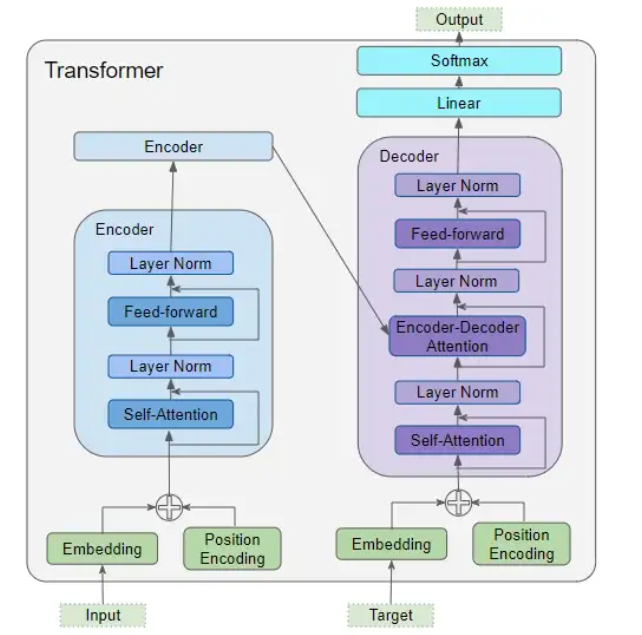

Note: In the SimpleLSTM the input question was encoded as one-hot vectors. Here in the Transformer, instead, the input question is encoded as sequence of embedding vectors, in which each vector represents a character.

The image below (taken always from https://towardsdatascience.com/transformers-explained-visually-part-2-how-it-works-step-by-step-b49fa4a64f34) represents a scheme of the attention formula I implemented in the Multi-Head Attention module.

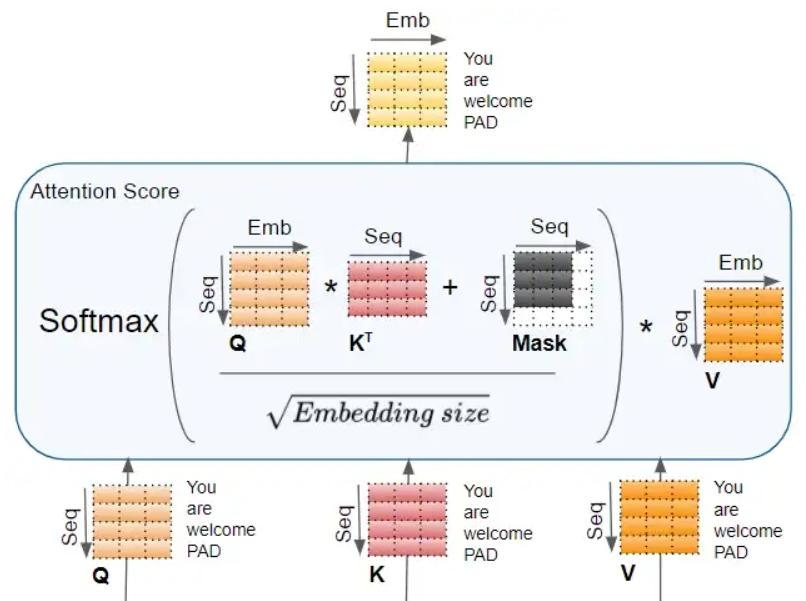

In [ ]:
class MultiHeadAttention(Module):
  '''
    calls:
    - attention_formula --> produce gli ATTENTION SCORES
  '''
  def __init__(self, num_head, d_model):
    super().__init__()
    self.num_head = num_head #8
    self.d_model = d_model   #512
    self.depth = self.d_model // self.num_head #64

    self.softmax = Softmax(dim=-1)
    self.dropout = Dropout(0.5)

    # linear layers for q, k, v
    self.query_linear = Linear(self.d_model, self.depth * self.num_head)
    self.key_linear = Linear(self.d_model, self.depth * self.num_head)
    self.value_linear = Linear(self.d_model, self.depth * self.num_head)
    # inizializzo i layer
    # self.query_linear.weight: tensore da inizializzare
    # std=np.sqrt(2.0 / (d_model + depth): the standard deviation of the normal distribution
    nn.init.normal_(self.query_linear.weight, mean=0, std=np.sqrt(2.0 / (self.d_model + self.depth)))
    nn.init.normal_(self.key_linear.weight, mean=0, std=np.sqrt(2.0 / (self.d_model + self.depth)))
    nn.init.normal_(self.value_linear.weight, mean=0, std=np.sqrt(2.0 / (self.d_model + self.depth)))
    # Layer-Normalization
    self.layer_norm = nn.LayerNorm(self.d_model)

  # the attention formula combines together the results of linear layers q, k, v and produces/computes the ATTENTION SCORES
  # I implemented this function looking at the image above
  def attention_formula(self, q, k, v, mask=None):
    q_k_mul = torch.bmm(q, k.transpose(1,2)) # Q*K, Q=(batch*num_head, len_seq_q, depth) * K=(batch*num_head, depth, len_seq_k_v), depth=depth check
    '''
      size of q_k_mul: (batch*num_head, len_seq_q, len_seq_k_v)
    '''
    # add the masking step: the masked out elements are set to negative infinity, so that Softmax turns those values to zero
    if mask is not None:
      q_k_mul += (mask * -1e9)

    # scale q_k_mul
    embed_size = k.size(dim=2) # depth
    input_to_softmax = q_k_mul / math.sqrt(embed_size)

    # apply the softmax so that the scores turn into probabilities (which add up to 1)
    attention_weights = self.softmax(input_to_softmax) # (batch*num_head, len_seq_q, len_seq_k_v)

    # another matrix moltiplication with the matrix v
    scaled_attention_weights = torch.bmm(attention_weights, v)  # ..=(batch*num_head, len_seq_q, len_seq_k_v) * v= (batch*num_head, len_seq_k_v, depth) = (batch*num_head, len_seq_q, depth)
    return scaled_attention_weights, attention_weights


  def forward(self, q, k, v, mask=None):
    '''
    viene chiamata 3 volte:
      nell'encoderlayer (encoder self-attention)
      nel decoderlayer (decoder self.attention)
      nel decoderlayer (end-dec-self-att): q = decoder_output, k = encoder_output, v = encoder_output
    '''
    batch_size = q.size(dim=0) #equal for all q,k,v
    len_seq_q = q.size(dim=1)
    len_seq_k_v = k.size(dim=1)

    # q,k,v are passed each through separate Linear layers in order to produce 3 different results: q,k,v
    q = self.query_linear(q).view(batch_size, self.num_head, len_seq_q, self.depth)
    k = self.key_linear(k).view(batch_size, self.num_head, len_seq_k_v, self.depth)
    v = self.value_linear(v).view(batch_size, self.num_head, len_seq_k_v, self.depth) # (batch, num_head, len_seq_k_v, depth)
    q = q.view(-1, len_seq_q, self.depth)  # (batch*num_head, len_seq_q, depth)
    k = k.view(-1, len_seq_k_v, self.depth)
    v = v.view(-1, len_seq_k_v, self.depth)

    # mask size: (batch, len_seq_q, len_seq_k_v)
    mask = mask.repeat(self.num_head, 1, 1) # mask size: (batch* num_head, len_seq_q, len_seq_k_v)
    scaled_attention_weights, attention_weights = self.attention_formula(q, k, v, mask)
    '''
     size of scaled_attention_weights: (batch, num_head, len_seq_q, depth)
     size of attention_weights:        (batch, num_head, len_seq_q, len_seq_k_v)
    '''
    scaled_attention_weights = scaled_attention_weights.transpose(1,2) # (batch, len_seq_q, num_head, len_seq_k_v)

    scaled_attention_weights = torch.reshape(scaled_attention_weights, (batch_size, -1, self.d_model)) # (batch, len_seq_q, d_model)

    # dropout is applied
    scaled_attention_weights = self.dropout(scaled_attention_weights)

    # application of the normalization layer
    out = self.layer_norm(scaled_attention_weights)

    '''
      size of out:               (batch, len_seq_q, d_model)
      size of attention_weights: (batch, num_head, len_seq_q, len_seq_k_v) --> same as earlier
    '''
    return out, attention_weights

In [ ]:
class FeedForward(Module):
  def __init__(self, d_model, d_inner):
    super().__init__()
    self.d_model = d_model
    self.d_inner = d_inner

    # two convolutions with kernel size 1
    self.conv1 = nn.Conv1d(self.d_model, self.d_inner, kernel_size=1)
    self.conv2 = nn.Conv1d(self.d_inner, self.d_model, kernel_size=1)
    self.relu = nn.ReLU()
    # residual skip-connection
    self.dropout = Dropout(0.5)
    # Layer-Normalization
    self.layer_norm = nn.LayerNorm(self.d_model)

  def forward(self, input):
    '''
      size of input: (batch, len_seq_q, d_model)
    '''
    # self.conv1 expects input size of: (batch, d_model, len_seq_q) so I transpose the input
    input = input.transpose(1,2)
    out = self.conv1(input) # (batch, d_inner, len_seq_q)
    out = self.relu(out)
    out = self.conv2(out)   # (batch, d_model, len_seq_q)
    out = out.transpose(1,2)
    out = self.dropout(out)
    out = self.layer_norm(out)

    return out # (batch, len_seq_q, d_model)

In [ ]:
class EncoderLayer(Module):
  def __init__(self, num_head, d_model, d_inner):
    super().__init__()
    self.num_head = num_head
    self.d_model = d_model
    self.d_inner = d_inner

    # inizialization of the modules MultiHeadAttention and FeedForward
    self.self_attention = MultiHeadAttention(self.num_head, self.d_model)
    self.feedforward = FeedForward(self.d_model, self.d_inner)

  def forward(self, encoder_input, diff_from_pad_mask=None, self_attention_mask=None):
    # in the Encoder’s Self-attention, the Encoder’s input is passed to all three parameters, Query, Key, and Value
    encoder_output, encoder_self_attention = self.self_attention(encoder_input, encoder_input, encoder_input, mask=self_attention_mask)
    encoder_output *= diff_from_pad_mask
    encoder_output = self.feedforward(encoder_output) # (batch, len_seq_q, d_model)
    encoder_output *= diff_from_pad_mask

    return encoder_output, encoder_self_attention

In [ ]:
class DecoderLayer(Module):
  def __init__(self, num_head, d_model, d_inner):
    super().__init__()
    self.num_head = num_head
    self.d_model = d_model
    self.d_inner = d_inner

    # inizialization of the modules MultiHeadAttention and FeedForward
    self.self_attention = MultiHeadAttention(self.num_head, self.d_model)
    # the Decoder has a second Multi-head attention layer, known as the Encoder-Decoder attention layer
    self.encoder_decoder_attention = MultiHeadAttention(self.num_head, self.d_model)
    self.feedforward = FeedForward(self.d_model, self.d_inner)

  def forward(self, decoder_input, encoder_output, diff_from_pad_mask=None, self_attention_mask=None, enc_dec_attention_mask=None):
    # the Encoder-Decoder attention combines two sources of inputs — the Self-attention layer below it as well as the output of the Encoder stack
    decoder_output, decoder_self_attention = self.self_attention(decoder_input, decoder_input, decoder_input, mask=self_attention_mask)
    decoder_output *= diff_from_pad_mask
    # in the Decoder’s Encoder-Decoder attention, the output of the final Encoder in the stack is passed to the Value and Key parameters
    #print("ENCODER - DECODER self-att")
    decoder_output, decoder_encoder_attention = self.self_attention(decoder_output, encoder_output, encoder_output, mask=enc_dec_attention_mask)
    decoder_output *= diff_from_pad_mask
    decoder_output = self.feedforward(decoder_output)
    decoder_output *= diff_from_pad_mask

    return decoder_output, decoder_self_attention, decoder_encoder_attention

Now I will implement the 3 main modules in order to build a complete transformer:
- **Encoder** module (that contains 6 Encoder layers)
- **Decoder** module (that contains 6 Decoder layers)
- **Transformer** module (that is made of both Encoder and Decoder module)


Useful functions:

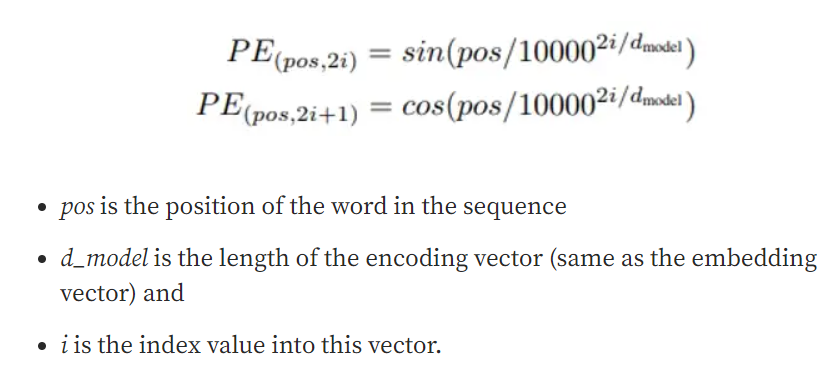

The positional encoding function is inspired by: https://github.com/Harin329/StockChek/blob/193b5c9e6009fb1f9fc01e93eb67e5621e2e3391/Stonkformers/Attention%20Is%20All%20You%20Need.ipynb and the mask functions are inspired by: https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Models.py.

In [ ]:
# POSITIONAL ENCODING
def get_angles(pos, i, embedd_dim):
  # look the image above
  return pos / np.power(10000, (2 * (i//2)) / np.float32(embedd_dim))

def get_pos_encoding_matrix(num_pos, embedd_dim, padding_idx):
  angle_rads = get_angles(np.arange(num_pos)[:, np.newaxis], np.arange(embedd_dim)[np.newaxis, :], embedd_dim)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_enc_matrix = angle_rads
  pos_enc_matrix[padding_idx, :] = 0.0
  #pos_enc_matrix = angle_rads[np.newaxis, ...]

  return torch.FloatTensor(pos_enc_matrix) # (1, num_pos, embedding_dim)

In [ ]:
# MASK FUNCTIONS
def get_self_attention_mask(key, query):
  '''
    in order to mask out the padding characters of the sequence
    Since I will need this function for the encoder-decoder attention in the DecoderLayer
    Nell'attention formnula dovrò sommare il prodotto tra matrici Q*K alla mask e quindi la maschera dovrà avere
    la stessa size di Q*K: (size: [batch, len_seq_q, len_seq_k_v])
  '''
  q_len = query.size(dim=1) # (batch, seq_len, dim_embedding)
  k_len = key.size(dim=1)
  padding_mask = key.eq(0)
  # torch.Size([64, 44, 512]) torch.Size([64, 1, 44, 512])
  padding_mask = padding_mask.unsqueeze(1).expand(-1, q_len, k_len)  # to have: (batch, len_seq_q, len_seq_k_v)
  return padding_mask

def get_diff_from_pad_mask(seq):
  # input.ne(other): A boolean tensor that is True where input is not equal to other and False elsewhere
  return seq.ne(0).type(torch.float).unsqueeze(-1)

def get_predict_next_mask(seq):
  # because the Decoder masks out input words that appear later in the sequence
  batch, seq_len = seq.size()
  subsequent_mask = torch.triu(torch.ones((seq_len, seq_len), device=seq.device, dtype=torch.uint8), diagonal=1)

  subsequent_mask = subsequent_mask.unsqueeze(0).expand(batch, -1, -1)  # batch x seq_len x seq_len
  return subsequent_mask

In [ ]:
def to_position(batch_quest=None, batch_ans=None):
  # quest size:  (batch, seq_len)
  # output size: (batch, seq_len)
  # max question length in the batch
  if batch_quest is not None:
    max_quest_len = batch_quest.size(dim=1)
    batch_quest_pos = np.array([[pos + 1 if char_index != 0 else 0 for pos, char_index in enumerate(q)] for q in batch_quest])
    batch_quest_pos = torch.LongTensor(batch_quest_pos)
  else:
    batch_quest_pos=None
  if batch_ans is not None:
    max_ans_len = batch_ans.size(dim=1)
    batch_ans_pos = np.array([[pos + 1 if char_index != 0 else 0 for pos, char_index in enumerate(a)] for a in batch_ans])
    batch_ans_pos = torch.LongTensor(batch_ans_pos)
  else:
    batch_ans_pos=None

  return batch_quest_pos, batch_ans_pos

In [ ]:
class EmbeddingTP(Module):
  def __init__(self, vocab_size, len_max_seq_enc, embedding_dim, d_model):
    super().__init__()
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.d_model = d_model
    self.num_position = len_max_seq_enc + 1

    # character embedding
    self.embedding = Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
    self.scale = torch.sqrt(torch.FloatTensor([self.d_model]))

    # position encoding for characters
    self.pos_encoding_matrix = get_pos_encoding_matrix(self.num_position, self.embedding_dim, padding_idx=0) # (1, num_pos, embedding_dim)
    self.position_encoding = Embedding.from_pretrained(self.pos_encoding_matrix, freeze=True)

    nn.init.normal_(self.embedding.weight, mean=0, std=1./math.sqrt(self.d_model))

  def forward(self, input):
    # input = [batch, seq_len]
    embed = self.embedding(input) * self.scale.to(device) # (batch, seq_len, embedding_dim)
    pos_embed = self.position_encoding(input) # (batch, seq_len, embedding_dim)

    final_embed = embed + pos_embed
    '''
      size of final_embed: (batch, seq_len, embedding_dim)
    '''
    return final_embed

In [ ]:
class Encoder(Module): # encoder with self-attention
  def __init__(self, vocab_size, len_max_seq_enc, embedding_dim, num_layers, num_head, d_model, d_inner):
    super().__init__()

    self.encoder_stack = nn.ModuleList([EncoderLayer(num_head, d_model, d_inner) for _ in range(num_layers)])

  def forward(self, input_quest, self_attention_mask, diff_from_pad_mask):
    '''
      size of input_quest: (batch, seq_len) - notice there is not the hot-encoding and the embedding is added later
    '''
    encoder_self_attention_list=[]
    for encoder_layer in self.encoder_stack:
      encoder_output, encoder_self_attention = encoder_layer(input_quest, diff_from_pad_mask=diff_from_pad_mask, self_attention_mask=self_attention_mask)
      encoder_self_attention_list += [encoder_self_attention]
    return encoder_output # (batch, len_seq_q, d_model)

In [ ]:
class Decoder(Module): # decoder with self-attention and encoder-decoder attention
  def __init__(self, vocab_size, len_max_seq_dec, embedding_dim, num_layers, num_head, d_model, d_inner):
    super().__init__()

    self.decoder_stack = nn.ModuleList([DecoderLayer(num_head, d_model, d_inner) for _ in range(num_layers)])

  def forward(self, target_ans, input_quest, enc_output, diff_from_pad_mask, self_attention_mask, enc_dec_attention_mask):
    '''
      size of target_ans: (batch, seq_len)
    '''
    dec_self_attention_list, dec_enc_attention_list = [], []
    for decoder_layer in self.decoder_stack:
      decoder_output, decoder_self_attention, decoder_encoder_attention = decoder_layer(target_ans, enc_output, diff_from_pad_mask=diff_from_pad_mask, self_attention_mask=self_attention_mask, enc_dec_attention_mask=enc_dec_attention_mask)
      dec_self_attention_list += [decoder_self_attention]
      dec_enc_attention_list += [decoder_encoder_attention]
    return decoder_output

The Transformer model is written in pytorch lightning in order to simplify the training calculations. It will combine the Encoder and the Decoder modules to solve the task.

In [ ]:
class Transformer(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.vocab_size = VOCAB_SIZE
    self.len_max_seq_enc = MAX_QUESTION_SIZE
    self.len_max_seq_dec = MAX_ANSWER_SIZE
    self.embedding_dim = 512
    self.d_model = 512
    self.d_inner = 2048
    self.num_layers = 6
    self.num_head = 8

    self.embedding = EmbeddingTP(self.vocab_size, self.len_max_seq_enc, self.embedding_dim, self.d_model)
    self.embedding.to(device)
    self.encoder = Encoder(self.vocab_size, self.len_max_seq_enc, self.embedding_dim, self.num_layers, self.num_head, self.d_model, self.d_inner)
    self.encoder.to(device)
    self.decoder = Decoder(self.vocab_size, self.len_max_seq_dec, self.embedding_dim, self.num_layers, self.num_head, self.d_model, self.d_inner)
    self.decoder.to(device)
    self.linear = Linear(self.d_model, self.vocab_size, bias=False)
    self.softmax = Softmax(dim=2)

    self.loss = BCEWithLogitsLoss()
    self.tot = 0
    self.n_correct = 0


  def forward(self, input_quest, target_ans):
    '''
    size of input_quest:              (batch, seq_len_quest)
    size of target_ans:               (batch, seq_len_ans)
    size of decoder out:              (batch, len_seq, d_model)
    size of decoder predicted_answer: (batch, len_seq)
    '''
    target_a = target_ans
    # ENCODER MASKS
    # the encoder layer calls 2 different mask functions: diff_from_pad_mask and self_attention_mask
    q_self_attention_mask = get_self_attention_mask(key=input_quest, query=input_quest)
    q_diff_from_pad_mask = get_diff_from_pad_mask(seq=input_quest)
    # DECODER MASKS
    a_diff_from_pad_mask = get_diff_from_pad_mask(seq=target_a)
    self_attention_next_mask = get_predict_next_mask(target_a)
    self_attention_mask_pad = get_self_attention_mask(key=target_a, query=target_a)
    self_attention_mask = (self_attention_mask_pad + self_attention_next_mask).gt(0)
    enc_dec_attention_mask = get_self_attention_mask(key=input_quest, query=target_a)

    input_quest = self.embedding(input_quest)
    target_a = self.embedding(target_a)

    encoder_out = self.encoder(input_quest.to(device), q_self_attention_mask, q_diff_from_pad_mask)
    decoder_out = self.decoder(target_a.to(device), input_quest, encoder_out, a_diff_from_pad_mask, self_attention_mask, enc_dec_attention_mask) # (batch, len_seq, d_model)

    # The linear layer outputs a score of the likelihood of occurrence of each word in the vocabulary, at each position in the output sequence
    out = self.linear(decoder_out) # (batch, len_seq, vocab_size)
    # The Softmax then converts those scores into probabilities
    out = self.softmax(out) # same shape of the input
    predicted_answer = torch.argmax(out, dim=2)
    '''
      size of out:              (batch, len_seq, vocab_size)
      size of predicted_answer: (batch, len_seq)  ->  because higher probability characters are chosen by argmax function
    '''
    res = {'out': out, 'predicted_answer': predicted_answer}
    res['target_answer'] = target_ans
    assert predicted_answer.size(dim=1) == target_ans.size(dim=1)
    acc = self.compute_accuracy(predicted_answer, target_ans)
    res['accuracy'] = acc
    target_aa = F.one_hot(target_ans, 95)
    loss = self.compute_loss(out, target_aa)
    res['loss'] = loss
    res['tot'] = self.tot
    res['n_correct'] = self.n_correct
    return res

  def training_step(self, batch):
    input_quest, target_ans = batch
    res = self.forward(input_quest, target_ans)
    train_loss = res['loss']
    train_acc = res['accuracy']
    num_tot_answers = res['tot']
    num_correct_answers = res['n_correct']
    self.log('train_loss', train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log('train_accuracy', train_acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log('total number of answers predicted', num_tot_answers, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log('number of correct answers', num_correct_answers, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    input_quest, target_ans = batch
    res = self.forward(input_quest, input_quest)
    ans_predicted = res['predicted_answer']
    ans = res['target_answer']
    val_loss = res['loss']
    val_acc = res['accuracy']
    metrics = {"val_loss": val_loss, "ans_predicted": ans_predicted, "ans": ans}
    self.log('validation_loss', val_loss, on_epoch=True, prog_bar=True, logger=True)
    self.log('validation_accuracy', val_acc, on_epoch=True, prog_bar=True, logger=True)
    return metrics

  def test_step(self, batch, batch_idx):
    input_quest, target_ans = batch
    res = self.forward(input_quest, input_quest)
    test_loss = res['loss']
    test_acc = res['accuracy']
    ans_predicted = res['predicted_answer']
    ans = res['target_answer']
    metrics = {"test_loss": test_loss, "ans_predicted": ans_predicted, "target_ans": ans}
    self.log('test_loss', test_loss, prog_bar = True)
    self.log('test_accuracy', test_acc, prog_bar = True)
    return metrics

  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=0.0006, betas=(0.9, 0.98), eps=1e-09)
    return optimizer

  def compute_loss(self, predicted_ans, target_ans):
    return self.loss(predicted_ans.float(), target_ans.float().to(device))

  def compute_accuracy(self, predicted_ans, target_ans):
    batch = predicted_ans.size(dim=0)
    for elem_in_batch in range(batch):
      self.tot += 1
      if torch.equal(predicted_ans[elem_in_batch], target_ans[elem_in_batch]):
        self.n_correct += 1
    return (self.n_correct/self.tot)*100

## Training

In [ ]:
# inizialization of the lightning module
transformer_pl = Transformer()

In [ ]:
'''5 SUB-PROBLEMS --------------------'''
# training step
trainer = pl.Trainer(accelerator='gpu', max_epochs=10, callbacks=[TQDMProgressBar(refresh_rate=5)])  # accelerator='gpu',
train_results = trainer.fit(transformer_pl, train_loader)
print(train_results)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: 

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('total number of answers predicted', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('number of correct answers', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


None


In [ ]:
'''3 SUB-PROBLEMS'''
# training step
trainer = pl.Trainer(accelerator='gpu', max_epochs=3, callbacks=[TQDMProgressBar(refresh_rate=5)])  # accelerator='gpu',
train_results = trainer.fit(transformer_pl, train_loader)
print(train_results)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | embedding | EmbeddingTP       | 132 K 
1 | encoder   | Encoder           | 17.3 M
2 | decoder   | Decoder           | 22.1 M
3 | linear    | Linear            | 48.6 K
4 | softmax   | Softmax           | 0     
5 | loss      | BCEWithLogitsLoss | 0     
------------------------------------------------
39.5 M    Trainable params
83.5 K    Non-trainable params
39.6 M    Total params
158.366   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

---PRED:  tensor([18, 18,  0], device='cuda:0')
-------TARGET:  tensor([18, 18,  0], device='cuda:0')
---PRED:  tensor([14, 18,  0], device='cuda:0')
-------TARGET:  tensor([14, 18,  0], device='cuda:0')


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


None


## Testing

In [ ]:
''' 5 SUB-PROBLEMS - INTERPOLATION -------------------------'''
# validation step
val_results = trainer.validate(transformer_pl, train_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy       37.65625762939453
     validation_loss        0.6988300085067749
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6988300085067749, 'validation_accuracy': 37.65625762939453}]


In [ ]:
''' 3 SUB-PROBLEMS - INTERPOLATION'''
# validation step
val_results = trainer.validate(transformer_pl, train_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy       45.48225021362305
     validation_loss        0.6989045739173889
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6989045739173889, 'validation_accuracy': 45.48225021362305}]


In [ ]:
''' 5 SUB-PROBLEMS - EXTRAPOLATION -----------------------------'''
# validation step
val_results = trainer.validate(transformer_pl, val_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy      34.871517181396484
     validation_loss        0.6988363265991211
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6988363265991211, 'validation_accuracy': 34.871517181396484}]


In [ ]:
''' 3 SUB-PROBLEMS - EXTRAPOLATION'''
# validation step
val_results = trainer.validate(transformer_pl, val_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy       36.5614013671875
     validation_loss        0.6988894939422607
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6988894939422607, 'validation_accuracy': 36.5614013671875}]


In [ ]:
''' 5 SUB-PROBLEMS - INTERPOLATION ---------------------------------'''
# test step
test_results = trainer.test(transformer_pl, train_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         32.492313385009766
        test_loss           0.6988300085067749
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.6988300085067749, 'test_accuracy': 32.492313385009766}]


In [ ]:
''' 5 SUB-PROBLEMS - EXTRAPOLATION ---------------------------------'''
# test step
test_results = trainer.test(transformer_pl, test_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          30.78887367248535
        test_loss           0.6988368630409241
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.6988368630409241, 'test_accuracy': 30.78887367248535}]


In [ ]:
''' 3 SUB-PROBLEMS - EXTRAPOLATION'''
# test step
test_results = trainer.test(transformer_pl, test_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          32.72911834716797
        test_loss           0.6988916993141174
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.6988916993141174, 'test_accuracy': 32.72911834716797}]


# 3° (SOTA) APPROACH: TP-TRANSFORMER

As State-of-the-Art approach a TP-Transformer is implemented.




In [ ]:
class TP_MultiHeadAttention(Module):
  def __init__(self, num_head, d_model):
    super().__init__()
    self.num_head = num_head
    self.d_model = d_model
    self.depth =self.d_model // self.num_head

    # linear layers for q, k, v
    self.query_linear = Linear(self.d_model, self.depth * self.num_head)
    self.key_linear = Linear(self.d_model, self.depth * self.num_head)
    self.value_linear = Linear(self.d_model, self.depth * self.num_head)
    self.role_linear = Linear(self.d_model, self.depth * self.num_head)

    self.out_linear = Linear(self.depth * self.num_head, self.d_model)
    self.dropout = Dropout(0.5)
    self.softmax = Softmax(dim=-1)

  def forward(self, q, k, v, mask=None):
    batch_size = q.size(dim=0)
    '''
      size of q, k, v: (batch, seq_len, d_model)
    '''
    q = self.query_linear(q) # nel enc-dec attention q = decoder_input = target_ans: (batch, seq_len_ANS, d_model)
    k = self.key_linear(k)
    v = self.value_linear(v)
    r = self.role_linear(q)
    q = q.view(batch_size, self.num_head, -1, self.depth)
    k = k.view(batch_size, self.num_head, -1, self.depth)
    v = v.view(batch_size, self.num_head, -1, self.depth)  # (batch, num_head, len_seq, depth)
    r = r.view(batch_size, self.num_head, -1, self.depth)

    embed_size = k.size(dim=2)
    dot = torch.einsum('bhid,bhjd->bhij', q, k) / math.sqrt(embed_size) # (batch, num_head, len_seq_q, len_seq_k)

    if mask is not None:
      dot = dot.masked_fill(mask==0, torch.tensor(-1e9).to(device))
    # find attention vector
    att_alpha = self.dropout(self.softmax(dot)) # (batch, num_head, len_seq_q, len_seq_k)
    # find filler vector
    filler = torch.einsum('bhjd,bhij->bhid', v, att_alpha) # (batch, num_head, len_seq_q, depth)

    # binding
    binding_filler_role = filler * r
    binding_filler_role.permute(0,2,1,3).contiguous() # (batch, len_seq_q, num_head, depth]
    binding_filler_role = binding_filler_role.reshape(batch_size, -1, self.num_head * self.depth)
    head_binding = self.out_linear(binding_filler_role)
    return head_binding


In [ ]:
class FeedForward(Module):
  def __init__(self, d_model, d_filter):
    super().__init__()

    self.d_model = d_model
    self.d_filter = d_filter

    self.linear1 = nn.Linear(d_model, d_filter)
    self.linear2 = nn.Linear(d_filter, d_model)
    self.dropout = nn.Dropout(0.5)
    self.relu = ReLU()

    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)

  def forward(self, input):
    '''
      size of input: (batch, seq_len, d_model)
    '''
    out = self.linear1(input)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.linear2(out)
    '''
      size of out: (batch, seq_len, d_model)
    '''
    return out

In [ ]:
class EncoderLayer(Module):
  def __init__(self, d_model, num_head, d_filter):
    super().__init__()
    self.d_model = d_model
    self.num_head = num_head
    self.d_filter = d_filter

    self.layer_norm1 = nn.LayerNorm(self.d_model)
    self.tp_self_attention = TP_MultiHeadAttention(self.num_head, self.d_model)
    self.dropout1 = Dropout(0.5)
    self.layer_norm2 = nn.LayerNorm(self.d_model)
    self.feedforward = FeedForward(self.d_model, self.d_filter)
    self.dropout2 = Dropout(0.5)
    self.layer_norm3 = nn.LayerNorm(self.d_model)


  def forward(self, quest, quest_mask):
    # quest size: (batch, seq_len_quest, d_model), quest_mask = (batch, seq_len_quest)
    enc_input = self.layer_norm1(quest)
    att = self.tp_self_attention(enc_input, enc_input, enc_input, quest_mask)
    att = self.dropout1(att)
    quest = quest + att

    quest = self.layer_norm2(quest)
    forward = self.feedforward(quest)
    forward = self.dropout2(forward)
    quest = quest + forward

    out = self.layer_norm3(quest)
    return out

In [ ]:
class DecoderLayer(Module):
  def __init__(self, d_model, num_head, d_filter):
    super().__init__()
    self.d_model = d_model
    self.num_head = num_head
    self.d_filter = d_filter

    self.layer_norm1 = nn.LayerNorm(self.d_model)
    self.tp_self_attention = TP_MultiHeadAttention(self.num_head, self.d_model)
    self.dropout1 = Dropout(0.5)

    self.layer_norm2 = nn.LayerNorm(self.d_model)
    self.tp_enc_dec_attention = TP_MultiHeadAttention(self.num_head, self.d_model)
    self.dropout2 = Dropout(0.5)

    self.layer_norm3 = nn.LayerNorm(self.d_model)
    self.feedforward = FeedForward(self.d_model, self.d_filter)
    self.dropout3 = Dropout(0.5)

    self.layer_norm4 = nn.LayerNorm(self.d_model)

  def forward(self, target, quest, target_mask, quest_mask):
    # self att
    dec_input = self.layer_norm1(target)
    att = self.tp_self_attention(dec_input, dec_input, dec_input, target_mask)
    att = self.dropout1(att)
    target = target + att
    # enc-dec att
    dec_input = self.layer_norm2(target)
    enc_dec_att = self.tp_enc_dec_attention(dec_input, quest, quest)
    enc_dec_att = self.dropout2(enc_dec_att)
    target = target + enc_dec_att
    # feedforward
    target = self.layer_norm3(target)
    forward = self.feedforward(target)
    forward = self.dropout3(forward)
    target = target + forward

    out = self.layer_norm4(target)
    return out

In [ ]:
class Encoder(Module):
  def __init__(self, num_layers, d_model, num_head, d_filter):
    super().__init__()

    self.encoder_stack = nn.ModuleList([EncoderLayer(d_model, num_head, d_filter) for _ in range(num_layers)])

  def forward(self, quest, quest_mask):
    for encoder_layer in self.encoder_stack:
      out_encoder = encoder_layer(quest, quest_mask)

    return out_encoder

In [ ]:
class Decoder(Module):
  def __init__(self, num_layers, d_model, num_head, d_filter):
    super().__init__()

    self.decoder_stack = nn.ModuleList([DecoderLayer(d_model, num_head, d_filter) for _ in range(num_layers)])

  def forward(self, target, quest, target_mask, quest_mask):
    for decoder_layer in self.decoder_stack:
      out_decoder = decoder_layer(target, quest, target_mask, quest_mask)

    return out_decoder

The mask function are taken from: https://github.com/ischlag/TP-Transformer/blob/master/models/tp-transformer.py

In [ ]:
class TP_Transformer(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.vocab_size = VOCAB_SIZE
    self.len_max_seq_enc = MAX_QUESTION_SIZE
    self.embedding_dim = 512
    self.d_filter = 2048
    self.num_layers = 6
    self.num_head = 8
    self.d_model = 512

    self.embedding = EmbeddingTP(self.vocab_size, self.len_max_seq_enc, self.embedding_dim, self.d_model)
    self.embedding.to(device)
    self.encoder = Encoder(self.num_layers, self.d_model, self.num_head, self.d_filter)
    self.encoder.to(device)
    self.decoder = Decoder(self.num_layers, self.d_model, self.num_head, self.d_filter)
    self.decoder.to(device)

    self.linear = Linear(self.d_model, self.vocab_size, bias=False)
    self.softmax = Softmax(dim=1)

    self.linear = Linear(self.d_model, self.vocab_size, bias=False)
    self.softmax = Softmax(dim=2)

    self.loss = BCEWithLogitsLoss()
    self.accuracy = Accuracy(task='binary')
    self.tot = 0
    self.n_correct = 0
    self.i = 0


  def create_mask(self, quest, target):
    quest_mask = (quest != 0).unsqueeze(1).unsqueeze(2)
    target_pad_mask = (target != 0).unsqueeze(1).unsqueeze(3)
    target_len = target.size(dim=1)

    trg_sub_mask = torch.tril(torch.ones((target_len, target_len), dtype=torch.uint8, device=target.device))

    trg_mask = target_pad_mask.type(torch.ByteTensor) & trg_sub_mask.type(torch.ByteTensor)
    return quest_mask.to(quest.device), trg_mask.to(quest.device)

  def forward(self, input_quest, target_a):
    # input_quest = (batch, len_seq_q)
    # target_a = (batch, len_seq_a)

    quest_mask, target_mask = self.create_mask(input_quest, target_a)
    # quest_mask = (batch, 1, 1, pad_seq)
    # target_mask = (batch, 1, pad_seq, past_seq)

    input_quest = self.embedding(input_quest)
    target_ans = self.embedding(target_a)
    # input_quest = (batch, seq_len_q, embedding_dim = d_model)

    out_encoder = self.encoder(input_quest, quest_mask)
    # out_encoder = (batch, seq_len_q, d_model)

    decoder_out = self.decoder(target_ans, out_encoder, target_mask, quest_mask)
    # decoder_out = (batch, seq_len_a, d_model)

    out = self.linear(decoder_out) # (batch, len_seq, vocab_size)
    out = self.softmax(out)
    predicted_answer = torch.argmax(out, dim=2)
    '''
      size of out:              (batch, len_seq, vocab_size)
      size of predicted_answer: (batch, len_seq)  ->  because higher probability characters are chosen by argmax function
    '''
    res = {'out': out, 'predicted_answer': predicted_answer}
    res['target_answer'] = target_a
    assert predicted_answer.size(dim=1) == target_a.size(dim=1)
    acc = self.compute_accuracy(predicted_answer, target_a)
    res['accuracy'] = acc
    target_a = F.one_hot(target_a, 95)
    loss = self.compute_loss(out, target_a)
    res['loss'] = loss
    res['tot'] = self.tot
    res['n_correct'] = self.n_correct
    return res

  def training_step(self, batch):
    input_quest, target_ans = batch
    res = self.forward(input_quest, target_ans)
    train_loss = res['loss']
    train_acc = res['accuracy']
    num_tot_answers = res['tot']
    num_correct_answers = res['n_correct']
    self.log('train_loss', train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log('train_accuracy', train_acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log('total number of answers predicted', num_tot_answers, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log('number of correct answers', num_correct_answers, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    input_quest, target_ans = batch
    res = self.forward(input_quest, input_quest)
    ans_predicted = res['predicted_answer']
    ans = res['target_answer']
    val_loss = res['loss']
    val_acc = res['accuracy']
    metrics = {"val_loss": val_loss, "ans_predicted": ans_predicted, "ans": ans}
    self.log('validation_loss', val_loss, prog_bar = True)
    self.log('validation_accuracy', val_acc, prog_bar = True)
    return metrics

  def test_step(self, batch, batch_idx):
    input_quest, target_ans = batch
    res = self.forward(input_quest, input_quest)
    test_loss = res['loss']
    test_acc = res['accuracy']
    ans_predicted = res['predicted_answer']
    ans = res['target_answer']
    metrics = {"test_loss": test_loss, "ans_predicted": ans_predicted, "target_ans": ans}
    self.log('test_loss', test_loss, prog_bar = True)
    self.log('test_accuracy', test_acc, prog_bar = True)
    return metrics

  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=0.0006, betas=(0.9, 0.98), eps=1e-09)
    return optimizer

  def compute_loss(self, predicted_ans, target_ans):
    return self.loss(predicted_ans.float(), target_ans.float().to(device))

  def compute_accuracy(self, predicted_ans, target_ans):
    batch = predicted_ans.size(dim=0)
    for elem_in_batch in range(batch):
      self.tot += 1
      if torch.equal(predicted_ans[elem_in_batch], target_ans[elem_in_batch]):
        self.n_correct += 1
    return (self.n_correct/self.tot)*100

## Training

In [ ]:
# inizialization of the lightning module
tp_transformer_pl = TP_Transformer()

In [ ]:
''' 5 SUB-PROBLEMS: '''
# training step
trainer = pl.Trainer(accelerator='gpu', max_epochs=10, callbacks=[TQDMProgressBar(refresh_rate=5)])  # accelerator='gpu',
train_results = trainer.fit(tp_transformer_pl, train_loader)
print(train_results)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | embedding | EmbeddingTP       | 132 K 
1 | encoder   | Encoder           | 20.5 M
2 | decoder   | Decoder           | 28.4 M
3 | linear    | Linear            | 48.6 K
4 | softmax   | Softmax           | 0     
5 | loss      | BCEWithLogitsLoss | 0     
6 | accuracy  | BinaryAccuracy    | 0     
------------------------------------------------
49.0 M    Trainable params
83.5 K    Non-trainable params
49.1 M    Total params
196.237   Total estima

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


None


In [ ]:
''' 3 SUB-PROBLEMS: '''
# training step
trainer = pl.Trainer(accelerator='gpu', max_epochs=3, callbacks=[TQDMProgressBar(refresh_rate=5)])  # accelerator='gpu',
train_results = trainer.fit(tp_transformer_pl, train_loader)
print(train_results)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | embedding | EmbeddingTP       | 132 K 
1 | encoder   | Encoder           | 20.5 M
2 | decoder   | Decoder           | 28.4 M
3 | linear    | Linear            | 48.6 K
4 | softmax   | Softmax           | 0     
5 | loss      | BCEWithLogitsLoss | 0     
6 | accuracy  | BinaryAccuracy    | 0     
------------------------------------------------
49.0 M    Trainable params
83.5 K    Non-trainable params
49.1 M    Total params
196.237   Total estima

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


None


## Testing

In [ ]:
''' 5 SUB-PROBLEMS - INTERPOLATION ---------------------'''
# validation step
val_results = trainer.validate(tp_transformer_pl, train_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy       94.71450805664062
     validation_loss        0.6897525191307068
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6897525191307068, 'validation_accuracy': 94.71450805664062}]


In [ ]:
''' 3 SUB-PROBLEMS - INTERPOLATION'''
# validation step
val_results = trainer.validate(tp_transformer_pl, train_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy        71.109619140625
     validation_loss        0.6940580606460571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6940580606460571, 'validation_accuracy': 71.109619140625}]


In [ ]:
''' 5 SUB-PROBLEMS - EXTRAPOLATION --------------------------'''
# validation step
val_results = trainer.validate(tp_transformer_pl, val_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy       87.89929962158203
     validation_loss        0.6897204518318176
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6897204518318176, 'validation_accuracy': 87.89929962158203}]


In [ ]:
''' 3 SUB-PROBLEMS - EXTRAPOLATION'''
# validation step
val_results = trainer.validate(tp_transformer_pl, val_loader)
print(val_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy       88.74349975585938
     validation_loss        0.6938731074333191
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'validation_loss': 0.6938731074333191, 'validation_accuracy': 88.74349975585938}]


In [ ]:
''' 5 SUB-PROBLEMS - INTERPOLATION -------------------'''
# test step
test_results = trainer.test(tp_transformer_pl, train_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          82.10570526123047
        test_loss           0.6897525191307068
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.6897525191307068, 'test_accuracy': 82.10570526123047}]


In [ ]:
''' 3 SUB-PROBLEMS - INTERPOLATION'''
# test step
test_results = trainer.test(tp_transformer_pl, train_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          57.25493240356445
        test_loss           0.6940580606460571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.6940580606460571, 'test_accuracy': 57.25493240356445}]


In [ ]:
''' 5 SUB-PROBLEMS - EXTRAPOLATION --------------------------'''
# test step
test_results = trainer.test(tp_transformer_pl, test_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          77.91852569580078
        test_loss           0.6897199749946594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.6897199749946594, 'test_accuracy': 77.91852569580078}]


In [ ]:
''' 3 SUB-PROBLEMS - EXTRAPOLATION'''
# test step
test_results = trainer.test(tp_transformer_pl, test_loader)
print(test_results)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          50.5687255859375
        test_loss           0.6938776969909668
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.6938776969909668, 'test_accuracy': 50.5687255859375}]


# COMPARISONS AND FINAL CONSIDERATIONS

The detailed analysis on the results obtained by the 3 approaches (the 2 baselines - SimpleLSTM and Transformer - and the State-of-the-Art approach - TP-Transformer - ) is written in the project paper.

